In [1]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Gate, library
from qiskit.compiler import transpile


import matplotlib.pyplot as plt

import numpy as np

def visualize_result(res):
    n_qubit = len(list(res.keys())[0])
    for i in range(2 ** n_qubit):
        label ="{0:b}".format(i).rjust(n_qubit, '0')
        if not label in res.keys():
            res[label] = 0
    
    sorted_res = dict(sorted(res.items()))

    print(sorted_res)

    plt.figure(figsize=(10,6))
    plt.title("Counts")
    plt.ylabel("Frequency")
    plt.xlabel("Measured State")
    plt.bar(sorted_res.keys(), sorted_res.values(), color='green')



In [2]:
def apply_zgate_2_exp(circuit, control_qubit, b_qubit_count):
    z_gate_matrix = np.array([
        [1, 0],
        [0, -1]
        ])
    
    z_gate_exp_matrix = np.linalg.matrix_power(z_gate_matrix, np.pow(2, control_qubit - b_qubit_count))

    z_gate_exp = library.UnitaryGate(z_gate_exp_matrix)
    controlled_z_gate_exp = z_gate_exp.control(1)

    circuit.append(controlled_z_gate_exp, [control_qubit] + list(range(b_qubit_count)))


def qft(circuit, b_qubit_count, c_qubit_count):
    for i in range(c_qubit_count + b_qubit_count - 1, b_qubit_count - 1, -1):
        circuit.h(i)
        for j in range(i - 1, b_qubit_count - 1, -1):
            circuit.cp(-2 * np.pi / np.pow(2, 2 - (j- (i-1))), j, i)

    for i in range(b_qubit_count, b_qubit_count + int(c_qubit_count / 2)):
        circuit.swap(i, b_qubit_count + c_qubit_count - (i - b_qubit_count) - 1)

In [3]:
def qpe(b,c):
    b = 1
    c = 3

    # circuit
    qr = QuantumRegister(b + c)
    cr = ClassicalRegister(b + c)

    qc = QuantumCircuit(qr, cr)

    qc.x(0)

    qc.h(list(range(b, b + c)))

    for i in range(b + c - 1, b - 1, -1):
        apply_zgate_2_exp(qc, i, b)

    qft(qc, b, c)

    qc.measure(list(range(b, b+c)), list(range(b, b+c)))

    return qc



{'0000': 0, '0001': 0, '0010': 0, '0011': 0, '0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 100000, '1001': 0, '1010': 0, '1011': 0, '1100': 0, '1101': 0, '1110': 0, '1111': 0}


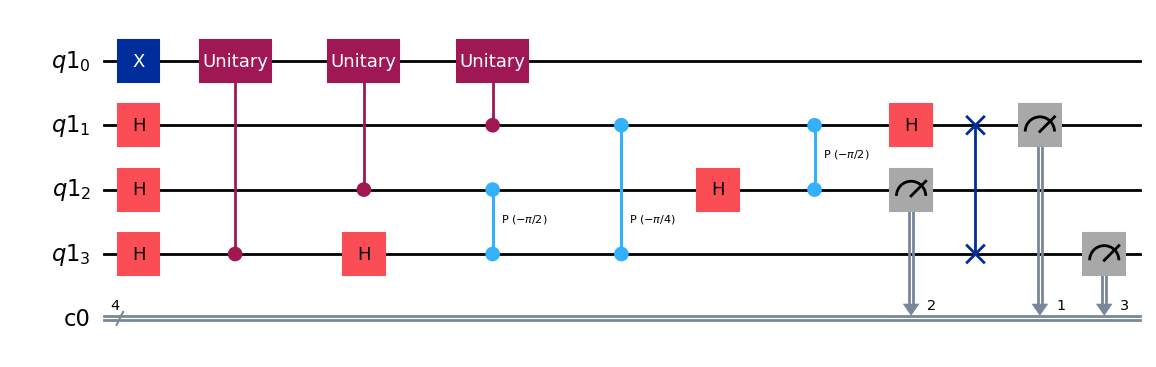

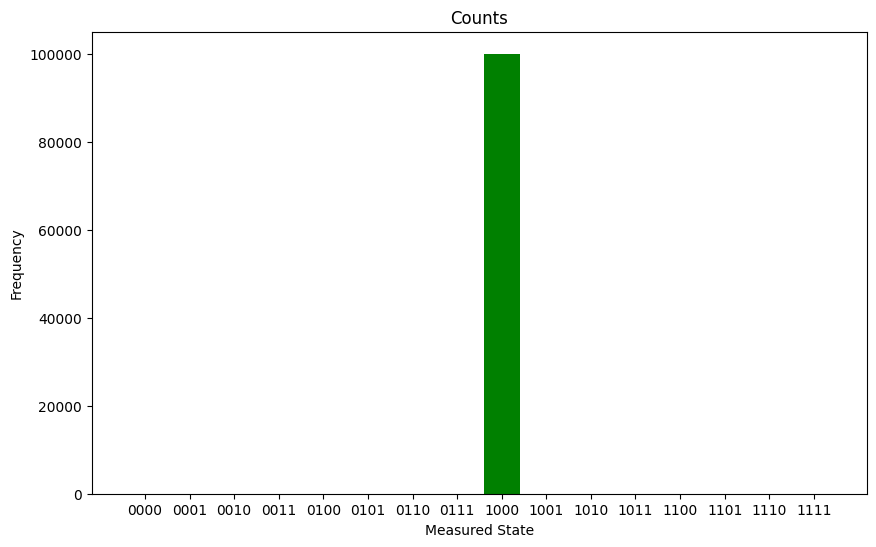

In [4]:
qc = qpe(1, 3)

qc.draw(output='mpl')

# execution
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

sim_result = simulator.run(compiled_circuit, shots=100000).result()
counts = sim_result.get_counts()

#visualization
visualize_result(counts)
qc.draw(output='mpl')